In [2]:
import pyemma as pm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import functions as funcs
import pickle
import time
import seaborn as sns

# Introduction

This plots the implied timescales and timescale ratios

In [3]:
m1_selection = pd.read_hdf('./summaries/m1_model_selection.h5')
m2_selection = pd.read_hdf('./summaries/m2_model_selection.h5')

In [5]:
m1_selection.sort_values(by=['protein', 'median_vamp'], ascending=False, inplace=True)
m2_selection.sort_values(by=['protein', 'median_vamp'], ascending=False, inplace=True)

In [6]:
sel_methods = {'m1': m1_selection, 'm2': m2_selection}

# Figure 1

1fme_its_logit

In [98]:
def quantile(data,ix, q=0.5):
    tmp = np.quantile(data, q=q, axis=0)
    return tmp.reshape(tmp.shape[0], -1)[:, ix]

def results(cktest, value='predictions'):
    y = quantile(cktest[value], ix=i, q=0.5)
    yerr = (quantile(cktest[value], ix=i, q=0.025), 
           quantile(cktest[value], ix=i, q=0.975))
    return y, yerr

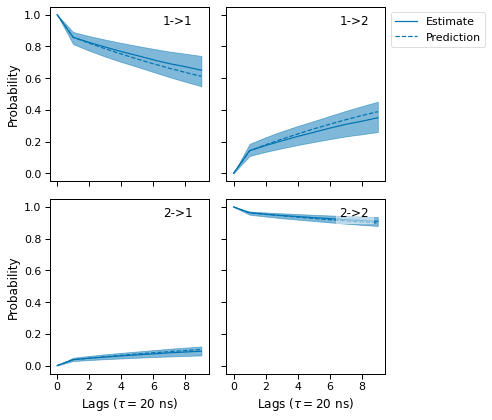

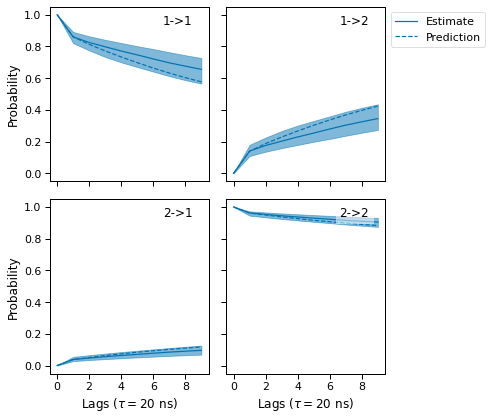

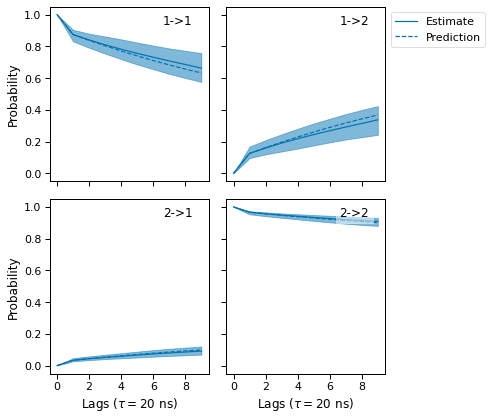

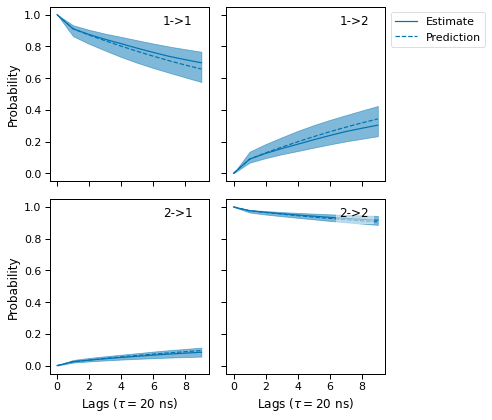

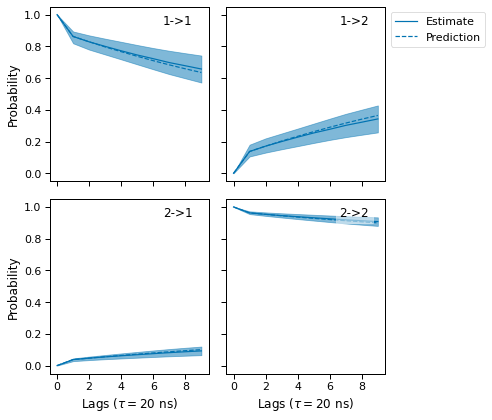

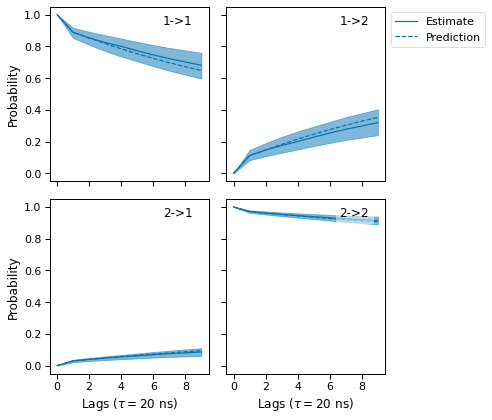

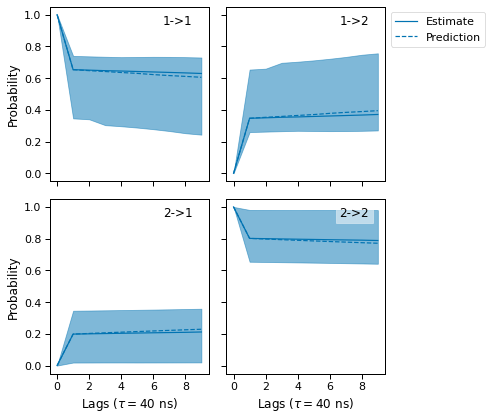

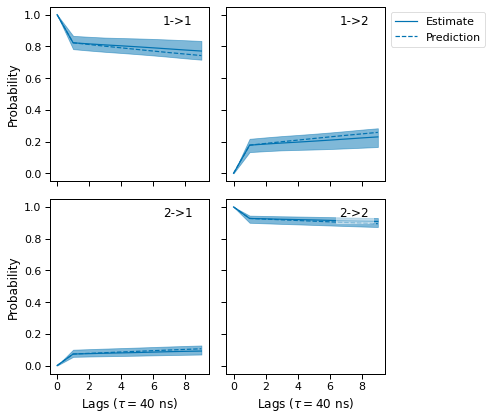

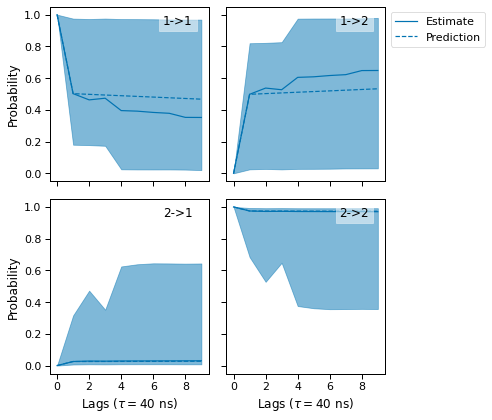

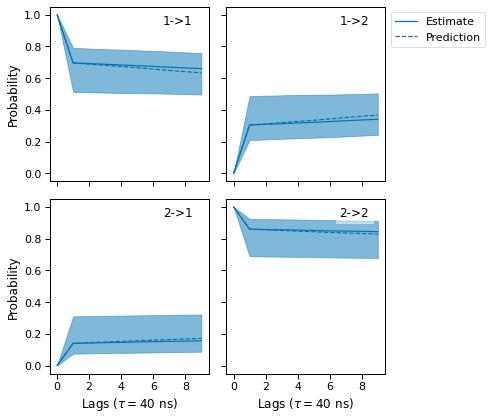

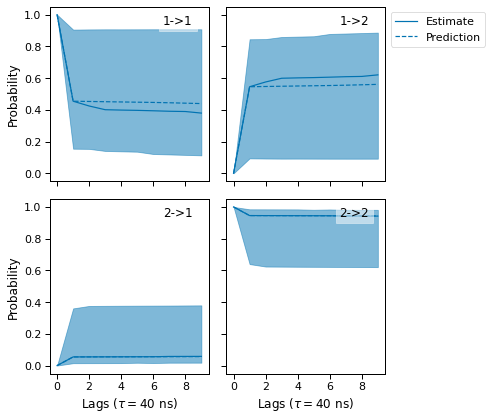

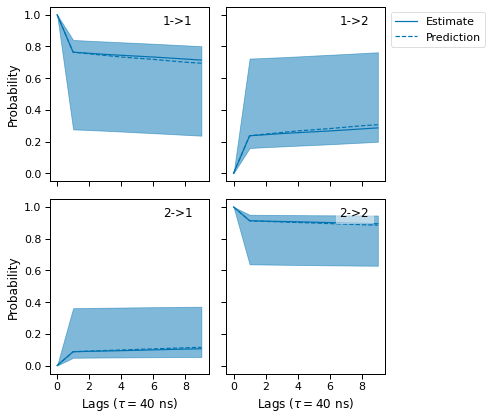

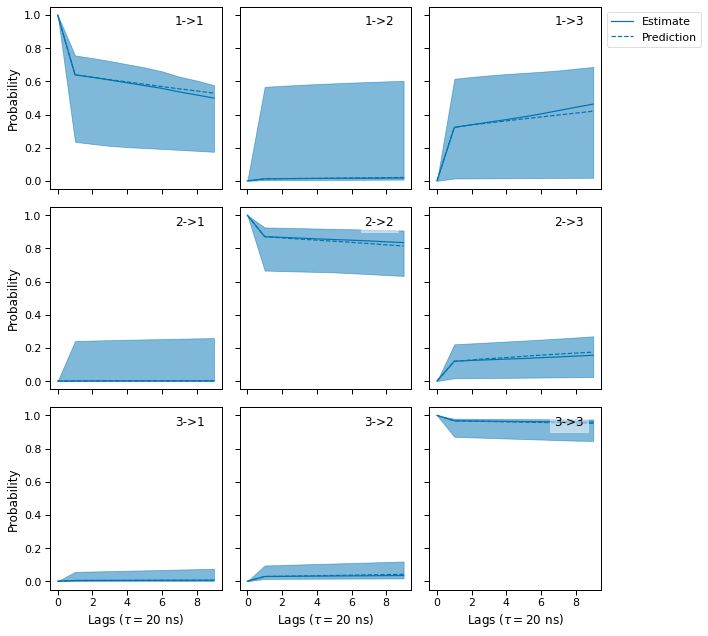

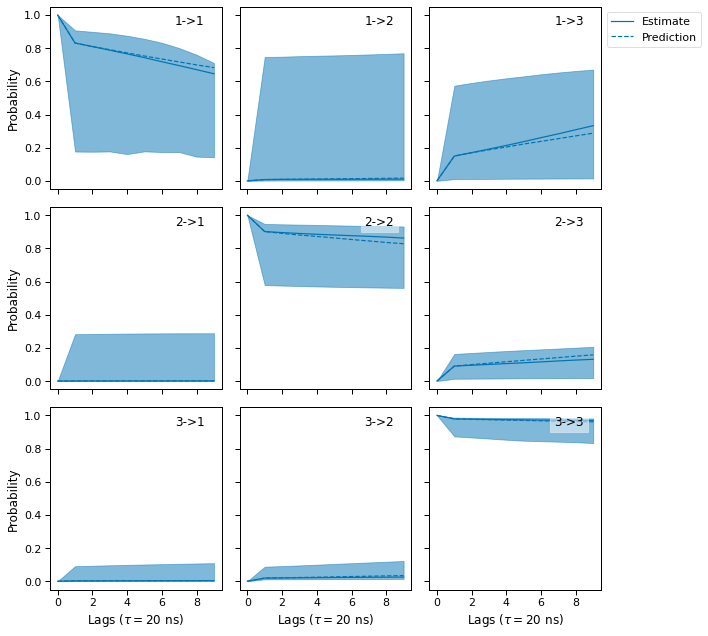

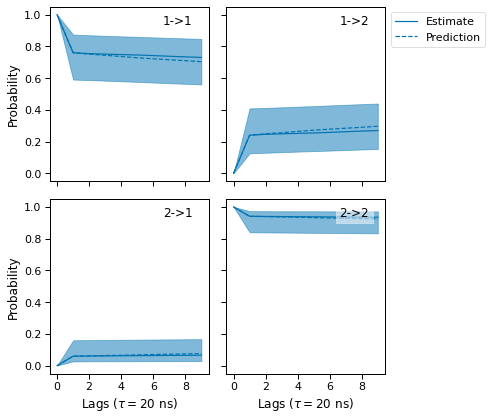

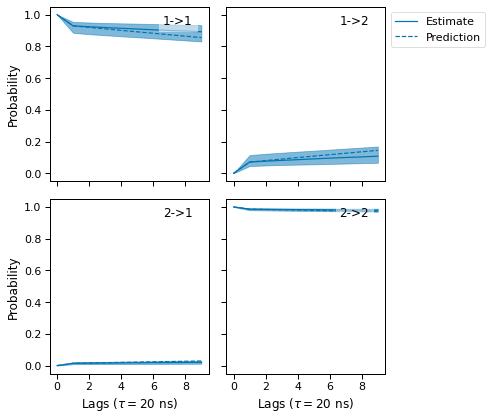

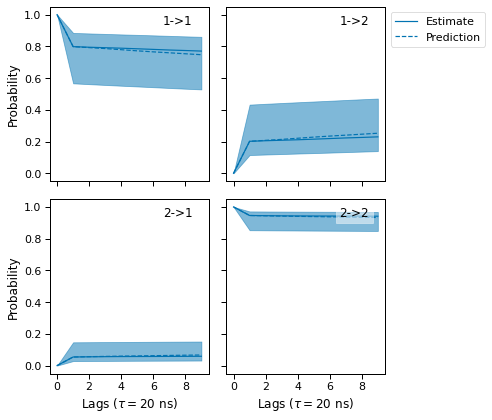

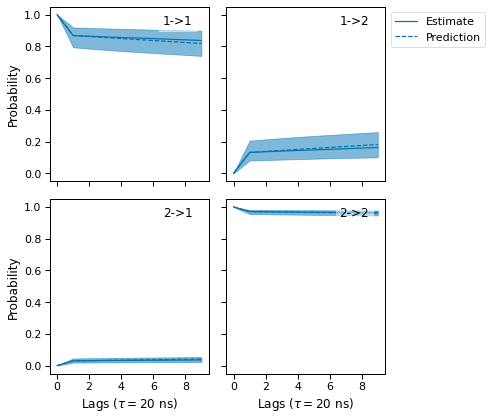

In [118]:
for protein in ['Chignolin',  'BBA', 'Trp-cage']:
    for feature in m1_selection.feature.unique():
        for method in sel_methods.keys():
            tmp = sel_methods[method].query(f"(protein=='{protein}') & (feature=='{feature}')")
            hp_ix = int(tmp['hp_index'].values[0])
            num_its = int(tmp['new_num_its'].values[0])
            lag = int(tmp['chosen_lag'])
            fname = f"{method}_{feature.replace('.','')}_hpix{hp_ix}_cktest.p"

            cktest = pickle.load(Path('ck_tests').joinpath(protein, fname).open('rb'))


            with sns.plotting_context('paper', font_scale=1.25):
                fig, axes = plt.subplots(num_its, num_its, figsize=(1+3*num_its, 3*num_its), sharex=True, sharey=True)
                cols = sns.color_palette('colorblind')

                for i, ax in enumerate(axes.flatten()):
                    lags = np.arange(cktest['predictions'].shape[1])

                    y, yerr = results(cktest, 'predictions')
                    ax.errorbar(lags, y, ls='--', color=cols[0], label='Prediction')

                    y, yerr = results(cktest, 'estimates')
                    ax.fill_between(lags, yerr[0], yerr[1], alpha=0.5, color=cols[0])
                    ax.plot(lags, y, color=cols[0], label='Estimate')

                    state_i, state_j = np.unravel_index(i, (num_its, num_its))
                    label = f"{state_i+1}->{state_j+1}"
                    ax.annotate(text=label, xy=(0.9, 0.9), xycoords='axes fraction', ha='right', 
                               bbox={'facecolor': 'w', 'alpha': 0.5, 'edgecolor': 'w'})

                    if state_i==num_its-1:
                        ax.set_xlabel(rf'Lags ($\tau={{{lag}}}$ ns)')
                    if state_j==0:
                        ax.set_ylabel("Probability")
                    if (state_i==0) and (state_j==num_its-1):
                        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

                plt.tight_layout()

                out_path = Path(funcs.FIG_DIR).joinpath('ck_tests', protein)
                out_path.mkdir(exist_ok=True, parents=True)

                plt.savefig(out_path.joinpath(fname.replace('.p', '.pdf')), bbox_inches='tight')


